Text Classification with Naive Bayes, Logistic Regression, SVM

Dataset : Economic news article tone and relevance from kaggle
- https://www.kaggle.com/datasets/heeraldedhia/us-economic-news-articles/data

In [32]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd 

import string
import re

import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


# import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix 
from sklearn import metrics

from time import time

Load and Explore the Data

In [33]:
data = pd.read_csv("../dataset/US-Economic-News.csv" , encoding = "ISO-8859-1" )

In [34]:
data.sample(3)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
2285,842615746,False,finalized,3,12/5/15 17:04,3.0,0.6323,yes,0.6323,wsj_914243754,1/6/12,Washington Isn't Spending Too Much; It's norma...,NaN,NaN,The Iowa caucuses presented the full range of ...
3630,842617094,False,finalized,3,12/5/15 1:43,7.0,0.6750,yes,1.0000,wsj_398486105,11/6/95,Business and Finance,NaN,NaN,CORPORATE EARNINGS rose 5% in the third quarte...
6288,830983919,False,finalized,3,11/17/15 18:57,NaN,0.0000,no,0.6718,wapo_141562392,3/10/61,Prices Mill Unevenly on Huge Turnover: 6 Milli...,NaN,NaN,NEW YORK. March 9 (AP)ÛÓStock market volume z...


In [35]:
display(data.shape)

(8000, 15)

In [36]:
data.shape[0]

8000

In [37]:
# Class distribution in the dataset
data['relevance'].value_counts()/data.shape[0]

relevance
no          0.821375
yes         0.177500
not sure    0.001125
Name: count, dtype: float64

- There is an imbalance in the data with not relevant being 82% in the dataset. That is, most of the articles are not relevant to US Economy, which makes sense in a real-world scenario, as news articles discuss various topics. We should keep this class imbalance mind when interpreting the classifier performance later.
-  Let us first convert the class labels into binary outcome variables for convenience. 1 for Yes (relevant), and 0 for No (not relevant), and ignore "Not sure"

In [38]:
data = data[data.relevance != "not sure"]
data.shape

(7991, 15)

In [39]:
data['relevance'] = data.relevance.map({'yes':1, 'no':0})
data = data[["text", 'relevance']]   # let's only consider only two columns
data.shape

(7991, 2)

In [40]:
data.sample(3)

,text,relevance
7940,So here's a paradox to ponder: By now everyone...,0
1225,U.S. economic activity appears to be holding s...,0
4090,NFVV YORK. April 11ÛÓÛªWall Street investors...,0


 2: Text Pre-processing:
 - we are performing the following steps: removing br tags, punctuation, numbers, and stopwords. 

In [41]:
stopwords =ENGLISH_STOP_WORDS

def clean(doc): # doc is a string of text
    doc = doc.replace("</br>", " ") # This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    # remove punctuation and numbers
    return doc

In [42]:
data.head()

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1


In [43]:
data['text'] = data['text'].apply(clean)
data.head()

,text,relevance
0,NEW YORK Yields certificates deposit offered m...,1
1,The Wall Street Journal Online The Morning Bri...,0
2,WASHINGTON In effort achieve banking reform Se...,0
3,The statistics enormous costs employee drug ab...,0
4,NEW YORK Indecision marked dollars tone trader...,1


We can also use nltk library to remove stopwards and lemmatize the text

In [44]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /home/db/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/db/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/db/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [46]:
def clean(doc): # doc is a string of text
    doc = doc.lower()  # Convert to lowercase
    doc = doc.replace("</br>", " ") # This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    # Tokenize the text
    tokens = word_tokenize(doc)
    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Remove stopwords
    cleaned_tokens = [token for token in lemmatized_tokens if token not in stopwords]
    # Join tokens back into a string
    cleaned_doc = " ".join(cleaned_tokens)
    
    return cleaned_doc

In [47]:
data['text'] = data['text'].apply(clean)
data.head()

,text,relevance
0,new york yield certificate deposit offered maj...,1
1,wall street journal online morning brief look ...,0
2,washington effort achieve banking reform senat...,0
3,statistic enormous cost employee drug abuse kn...,0
4,new york indecision marked dollar tone trader ...,1


3: Modeling
- Now we are ready for the modelling. We are going to use algorithms from sklearn package. We will go through the following steps:

1.  Split the data into training and test sets (75% train, 25% test)
2. Extract features from the training data using CountVectorizer, which is a bag of words feature implementation. We will use the pre-processing function above in conjunction with Count Vectorizer
3. Transform the test data into the same feature vector as the training data.
4. Train the classifier
5. Evaluate the classifier

In [48]:
import sklearn
from sklearn.model_selection import train_test_split

X = data.text # the column text contains textual data to extract features from
y = data.relevance # this is the column we are learning to predict. 
print(X.shape, y.shape)

(7991,) (7991,)


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5993,) (5993,)
(1998,) (1998,)


 "dtm" stands for "Document-Term Matrix."
 - Its a mathematical matrix that describes the frequency of terms that occur in a collection of documents. 
 - Each row represents a document, and each column represents a term. The values in the matrix are typically the counts of how many times each term (word) appears in each document.

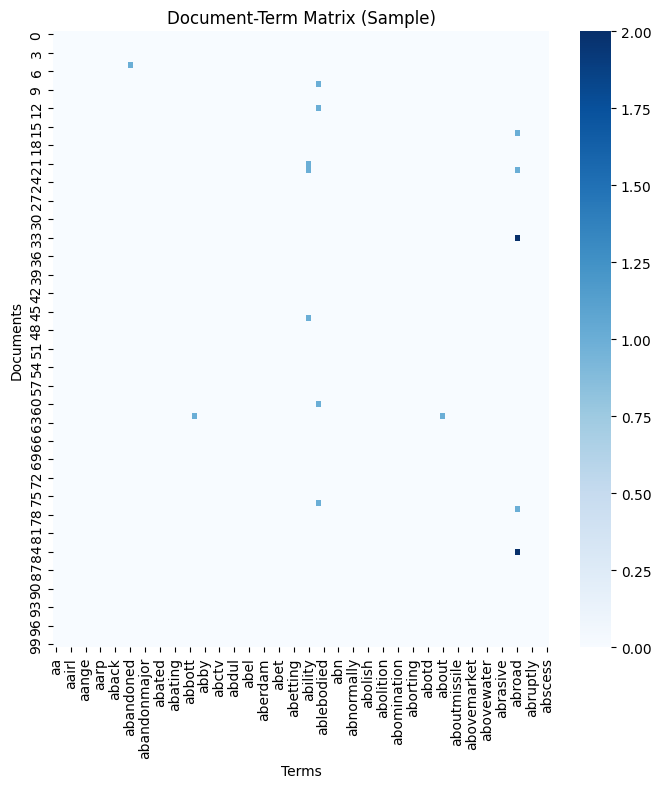

In [53]:
import seaborn as sns

# Convert X_train_dtm to a DataFrame for easier visualization
X_train_dtm_df = pd.DataFrame(X_train_dtm.toarray(), columns=vect.get_feature_names_out())

# Plot heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(X_train_dtm_df.iloc[:100, :100], cmap='Blues')
plt.xlabel('Terms')
plt.ylabel('Documents')
plt.title('Document-Term Matrix (Sample)')
plt.show()


In [50]:
# Step 2-3: Preprocess and Vectorize train and test data
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train) 
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)

(5993, 39645) (1998, 39645)


In [51]:
X_train_dtm
# the dimension of our feature vector is 39645!

<5993x39645 sparse matrix of type '<class 'numpy.int64'>'
	with 556719 stored elements in Compressed Sparse Row format>

In [52]:
# Step 3: Train the classifier and predict for test data
nb = MultinomialNB()   # instantiate a Multinomial Naive Bayes model

%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")
# Given the 

CPU times: user 6.27 ms, sys: 404 µs, total: 6.68 ms
Wall time: 6.05 ms


MultinomialNB()

In [58]:
y_pred_class = nb.predict(X_test_dtm) # make class predictions for X_test_dtm

In [59]:
# Step 4: Evaluate the classifier using various measures

import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes, 
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

print("Accuracy: ", accuracy_score(y_test, y_pred_class))

    

Accuracy:  0.7607607607607607


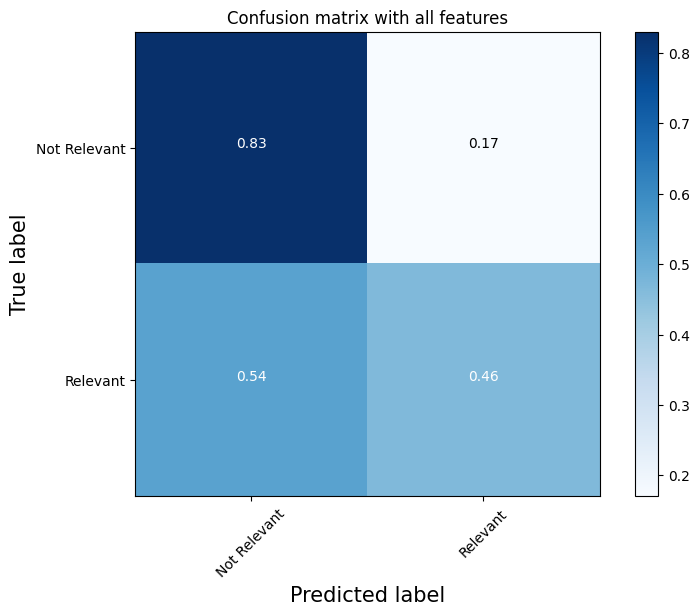

In [60]:
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with all features')

In [61]:

# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))

ROC_AOC_Score:  0.7375510745078275


- At this point, we can notice that the classifier is doing poorly with identifying relevant articles, while it is doing well with non-relevant ones. 
- Our large feature vector could be creating a lot of noise in the form of very rarely occurring features that are not useful for learning. 
- Let us change the count vectorizer to take a certain number of features as maximum.

CPU times: user 5.75 ms, sys: 363 µs, total: 6.11 ms
Wall time: 6.14 ms
Accuracy :  0.6816816816816816


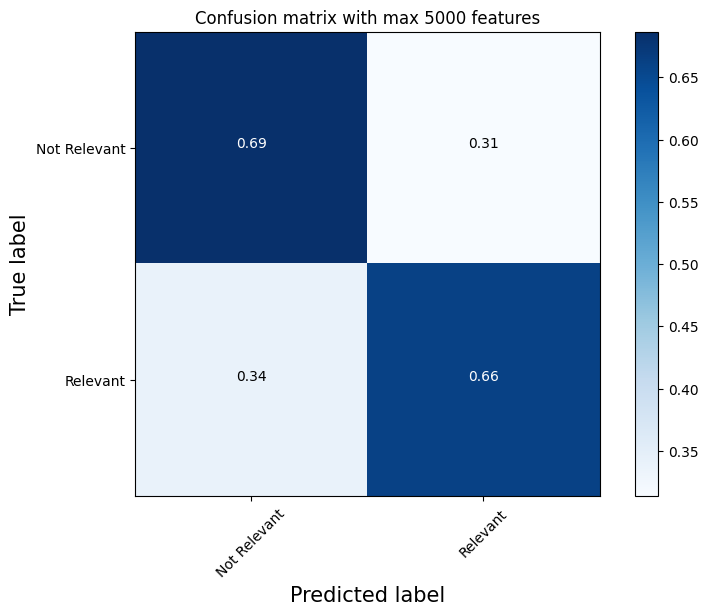

In [62]:
vect = CountVectorizer(max_features=5000)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

nb = MultinomialNB()

%time nb.fit(X_train_dtm, y_train)

y_pred_class = nb.predict(X_test_dtm)
print("Accuracy : ", metrics.accuracy_score(y_test, y_pred_class))

cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8, 6))

plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],
                      normalize=True,
                      title='Confusion matrix with max 5000 features')

- Clearly, the performance on relevance classification got better even though the overall accuracy fell by 10%. 
- Let us try another classification algorithm and see if the performance changes. 
- will now use Logistic Regression, with class_weight attribute as "balanced", to address the problem of class imbalance in this dataset.


In [63]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(class_weight="balanced")
log_reg.fit(X_train_dtm, y_train)

# Make predictions on test data
y_pred_class = log_reg.predict(X_test_dtm)

Accuracy :  0.7337337337337337
ROC_AOC_Score: :  0.7375510745078275


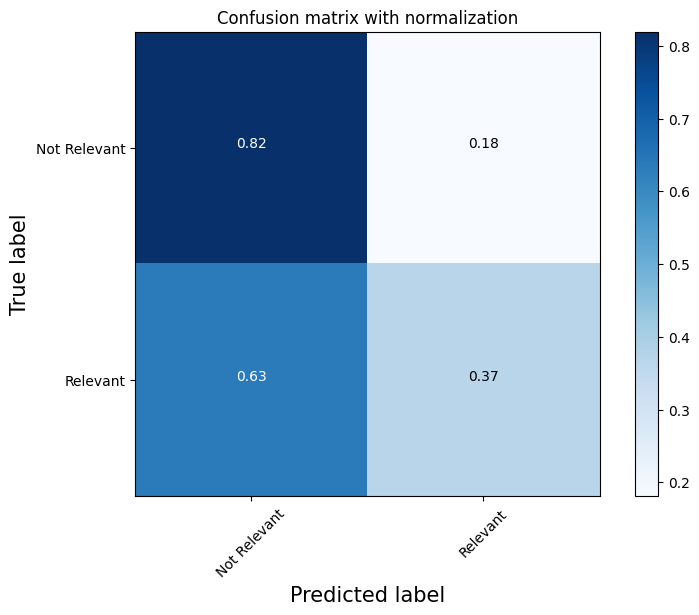

In [64]:
# calculate evaluation measures:

print("Accuracy : ", accuracy_score(y_test, y_pred_class))
print("ROC_AOC_Score: : ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

- The performance on Irrelevance classification got better but the relevant classification perform poor.
- The overall accuracy increased by 5%

Lets try another Classifier by limiting feature vector size

Accuracy:  0.6766766766766766
ROC_AOC_Score:  0.7375510745078275


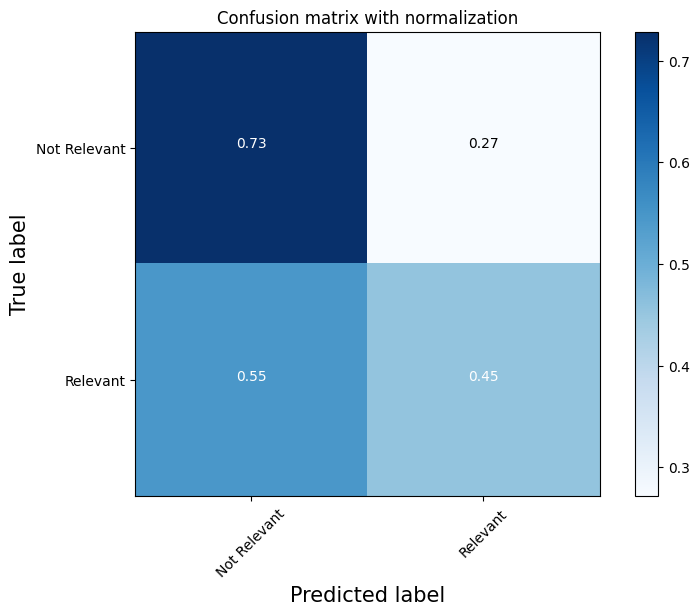

In [65]:
from sklearn.svm import LinearSVC

vect = CountVectorizer(preprocessor=clean, max_features=1000) # Step-1
X_train_dtm = vect.fit_transform(X_train) # combined step 2 and 3
X_test_dtm = vect.transform(X_test)

classifier = LinearSVC(class_weight='balanced') # instantiate a logistic regression model
classifier.fit(X_train_dtm, y_train) # fit the model with training data

# Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

# calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

- So, how do we choose whats the best? If we look at overall accuracy alone, we should be choosing the very first classifier in this notebook. 
- However, that is also doing poorly with identifying "relevant" articles. If we choose purely based on how good it is doing with "relevant" category, we should choose the second one we built.
- If we choose purely based on how good it is doing with "irrelevant" category, surely, nothing beats not building any classifier and just calling everything irrelevant! 
- So, what to choose as the best among these depends on what we are looking for in our usecase!